<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/%237DaysOfCode/dia_3_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7DaysOfCode - Ciência de Dados 3/7: Forecasting

É hora de encarar o terceiro dia de desafio!

E como você já viu, a tarefa hoje é: Forecasting. Vou te explicar melhor o que é isso.

O trabalho de um Cientista de Dados geralmente gira em torno de duas principais frentes: descrição (entender o que aconteceu e por que aconteceu) e predição (prever o que pode acontecer e o que deve ser feito).

É provável que ontem você tenha aplicado algumas dessas técnicas descritivas, utilizando análise de dados e visualizações para entender o que aconteceu.

Neste caso, você analisou o que aconteceu com os gastos dos senadores.

Para as tarefas de predição, são utilizadas técnicas de Machine Learning e ferramentas estatísticas para prever o futuro. E é sobre elas que falaremos hoje.

Forecasting é uma das técnicas mais conhecidas e utilizadas por Data Scientists para prever indicadores de negócios.

Por exemplo: uma área de Finanças pode querer que você preveja o faturamento da empresa; ou então seu time de Marketing pode querer prever quantos usuários irão se cadastrar na plataforma nos próximos meses.

No desafio de hoje, eu quero te provocar a criar o seu próprio modelo de Forecasting!

Será que você consegue criar um modelo que irá prever quanto os senadores vão gastar nos próximos três meses?

Você ainda utilizará o dataset do CEAPS que utilizou ontem, mas será muito importante para o seu modelo que você tenha mais de um ano de dados.

Os dados do CEAPS são divididos por ano, então seria interessante pegar pelo menos quatro anos e juntar em um grande dataset (isso fará seu modelo mais preciso).

Mas, se você não tem tempo pra isso, não tem problema. Eu já fiz um dataset para esse desafio, que você pode baixar aqui. Esse dataset contém dados de 2018 a 2021 do CEAPS, e nele você encontrará duas colunas:

DS, que representa a data do reembolso; 
Y, que é a soma de reembolsos dos senadores naquele dia.

# Importar Bibliotecas

In [433]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from datetime import datetime
import datetime
!pip install prophet
from prophet import Prophet


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Importar Dataset feito no dia 1.

In [434]:
link = "/gdrive/MyDrive/Colab Notebooks/#7DaysOfCode/"

despesa_ceaps_full = pd.read_csv(link+"despesa_ceaps_full.csv", sep=',')

despesa_ceaps_full = despesa_ceaps_full.drop('Unnamed: 0', axis=1)

In [435]:
despesa_ceaps_full.columns

Index(['ANO', 'MES', 'SENADOR', 'TIPO_DESPESA', 'CNPJ_CPF', 'FORNECEDOR',
       'DATA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO', 'SEM_DOCUMENTO',
       'SEM_DETALHAMENTO'],
      dtype='object')

In [436]:
despesa_ceaps_full.head(3)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,SEM_DOCUMENTO,SEM_DETALHAMENTO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,66.020,0.000,0.000
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,139.980,0.000,0.000
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000.000,0.000,0.000


# Preparar dataset para Forecasting

In [437]:
despesa_ceaps_full['dia'] = despesa_ceaps_full['DATA'].astype('string').str[0:2].astype(int)
despesa_ceaps_full['mes'] = despesa_ceaps_full['MES'].astype('string')
despesa_ceaps_full['ano'] = despesa_ceaps_full['ANO'].astype('string')

In [438]:
datetime_despesa_ceaps_full = pd.DataFrame({'year': despesa_ceaps_full['ano'].astype('string').tolist(), 
                                            'month': despesa_ceaps_full['mes'].astype('string').tolist(), 
                                            'day': despesa_ceaps_full['dia'].astype('string').tolist()})

In [439]:
datetime_despesa_ceaps_full['year'].unique()

array(['2019', '2020', '2021', '2022'], dtype=object)

In [440]:
datetime_despesa_ceaps_full[datetime_despesa_ceaps_full['year']=='2022']['month']

52532    1
52533    1
52534    1
52535    1
52536    1
        ..
56276    4
56277    4
56278    4
56279    4
56280    4
Name: month, Length: 3749, dtype: object

In [441]:
datetime_despesa_ceaps_full[datetime_despesa_ceaps_full['year']=='2022'][datetime_despesa_ceaps_full['month']=='1']['day'].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


'9'

In [442]:
datetime_despesa_ceaps_full['datetime'] = datetime_despesa_ceaps_full['year'].astype('string')+'/'\
                                          +datetime_despesa_ceaps_full['month'].astype('string')+'/'\
                                          +datetime_despesa_ceaps_full['day'].astype('string')

In [443]:
despesa_ceaps_full['datetime'] = pd.to_datetime(datetime_despesa_ceaps_full['datetime'],  infer_datetime_format = True , errors='coerce')

In [444]:
despesa_ceaps_full.tail(3)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,SEM_DOCUMENTO,SEM_DETALHAMENTO,dia,mes,ano,datetime
56278,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,04/04/2022,"Companhia Aérea: GOL, Localizador: QVOLRY. Pas...",1681.230,0.000,0.000,4,4,2022,2022-04-04
56279,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,06/04/2022,"Companhia Aérea: AZUL, Localizador: JBHH5Y. Pa...",1663.610,0.000,0.000,6,4,2022,2022-04-06
56280,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,06/04/2022,"Companhia Aérea: LATAM, Localizador: FRFFFI. P...",2324.000,0.000,0.000,6,4,2022,2022-04-06


In [445]:
despesa_ceaps_full_forecasting = despesa_ceaps_full[['datetime', 'VALOR_REEMBOLSADO']].sort_values(by='datetime')

In [446]:
despesa_ceaps_full_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56281 entries, 2283 to 55993
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           56081 non-null  datetime64[ns]
 1   VALOR_REEMBOLSADO  56281 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


In [447]:
despesa_ceaps_full

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,SEM_DOCUMENTO,SEM_DETALHAMENTO,dia,mes,ano,datetime
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,66.020,0.000,0.000,4,1,2019,2019-01-04
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,139.980,0.000,0.000,4,1,2019,2019-01-04
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000.000,0.000,0.000,7,1,2019,2019-01-07
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,25/12/2018,Despesa com pagamento de telefonia para o escr...,316.390,0.000,0.000,25,1,2019,2019-01-25
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/02/2019,Despesa com pagamento de energia elétrica para...,99.450,0.000,0.000,4,2,2019,2019-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56276,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,02/04/2022,"Companhia Aérea: LATAM, Localizador: FXMSVF. P...",1361.660,0.000,0.000,2,4,2022,2022-04-02
56277,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,02/04/2022,"Companhia Aérea: LATAM, Localizador: VLNWSC. P...",2723.230,0.000,0.000,2,4,2022,2022-04-02
56278,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,04/04/2022,"Companhia Aérea: GOL, Localizador: QVOLRY. Pas...",1681.230,0.000,0.000,4,4,2022,2022-04-04
56279,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,06/04/2022,"Companhia Aérea: AZUL, Localizador: JBHH5Y. Pa...",1663.610,0.000,0.000,6,4,2022,2022-04-06


In [448]:
despesa_ceaps_full_forecasting[despesa_ceaps_full_forecasting['datetime'].isnull()]['datetime']

381     NaT
425     NaT
447     NaT
565     NaT
739     NaT
         ..
55387   NaT
55572   NaT
55964   NaT
55992   NaT
55993   NaT
Name: datetime, Length: 200, dtype: datetime64[ns]

In [449]:
despesa_ceaps_full_forecasting

,datetime,VALOR_REEMBOLSADO
2283,2019-01-01,252.000
4139,2019-01-01,673.200
8318,2019-01-01,195.140
10458,2019-01-01,105.260
10459,2019-01-01,148.320
...,...,...
55387,NaT,3000.000
55572,NaT,165.360
55964,NaT,3100.000
55992,NaT,2101.350


In [450]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.groupby('datetime').sum().sort_values(by='datetime')

In [451]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.reset_index()

In [452]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.rename(columns={'datetime':'ds',
                                               'VALOR_REEMBOLSADO': 'y'})

In [453]:
despesa_ceaps_full_forecasting.tail(3)

,ds,y
1203,2022-04-28,1379.660
1204,2022-04-29,1530.180
1205,2022-04-30,980.720


# Modelo de Forecasting: Prophet

In [454]:
p = Prophet()

In [455]:
p.fit(despesa_ceaps_full_forecasting)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [456]:
future = p.make_future_dataframe(periods=90)

In [457]:
forecast = p.predict(future)

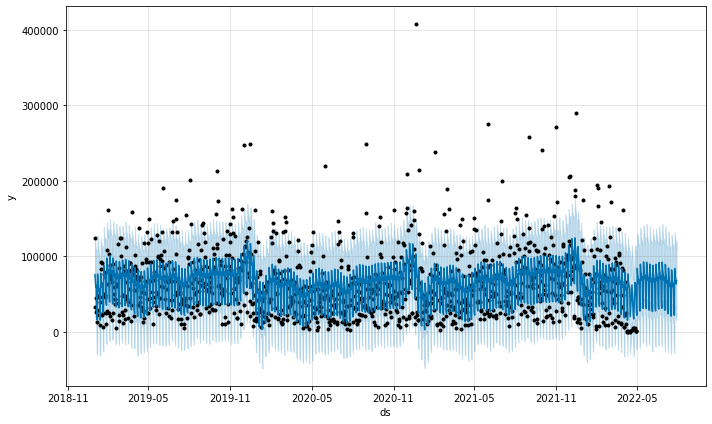

In [458]:
fig1 = p.plot(forecast)

In [459]:
pd.options.display.float_format = '{:.3f}'.format
forecast[['yhat']].iloc[-90:].sum()

yhat   5646995.670
dtype: float64

**Daqui 90 dias, os senadores irão gastar aproximadamente 5 milhões e meio de reais!**

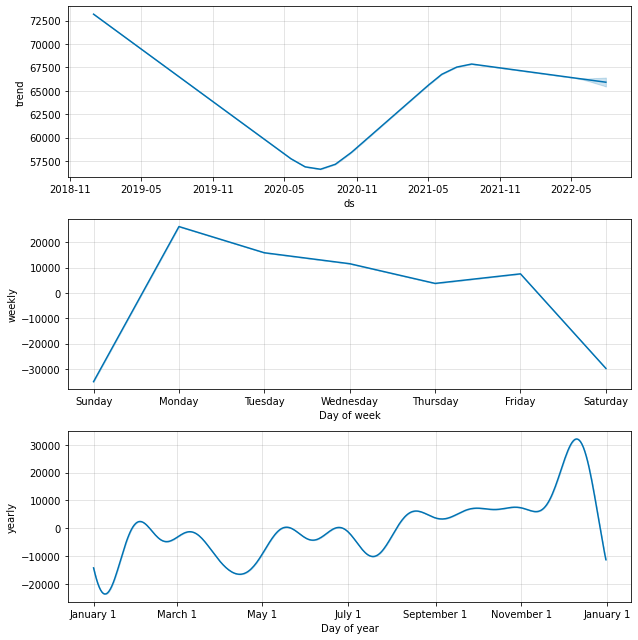

In [460]:
fig2 = p.plot_components(forecast)

* A tendência é que os gastos diminuam.
* Os gastos diários na segunda-feira começam altos e diminuem conforme passa a semana. 
* No final do ano, os gastos diários ultrapassam 100 mil reais por dia.
